In [275]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from tqdm import tqdm
import os
import json
import random
from numpy import longdouble
from sklearn.utils import shuffle
# import pathos.multiprocessing as mpathos
import sentencepiece as spm
import nltk
from sklearn.feature_extraction.text import CountVectorizer
# import cupy as cp
# import numpy_ml.neural_nets.losses as CE

sp = spm.SentencePieceProcessor()
sp.load('spm_model_2.5k_justPeriods_lowercase.model')

text = "this is a sample sentence to tokenize."
tokens = sp.encode_as_pieces(text)
print(tokens)
print(sp.encode_as_ids(text))
def strip_non_alphanumeric_except_periods_and_spaces(text):
    # Replace all non-alphanumeric characters except periods and spaces with an empty string
    return re.sub(r'[^a-zA-Z0-9. ]+', '', text)print(sp.decode(sp.encode_as_ids(text)))

SyntaxError: invalid syntax (2412976649.py, line 26)

In [ ]:
# def find_max_sequence_length():
#     maxlen = 0
#     prefix = './PhishingEmails/'  # Adjust this to your file path
    
#     for file in tqdm(os.listdir(prefix)):
#         with open(prefix + file) as jsonFile:
#             jsonStr = jsonFile.read()
#             email_dict = json.loads(jsonStr)
#             setupData = sp.encode_as_ids(stripMost(email_dict['email_subject'].strip().lower()).strip() + " " + stripMost(email_dict['email_body'].strip()).lower().strip())

#             if(len(setupData) < 801):
#                 maxlen = max(maxlen, len(setupData))

#     return maxlen

In [ ]:
from numpy import uint8


def one_hot(vocab_size, sequence):
    v_sequence = []
    for token in sequence:
        vectorized = np.zeros(vocab_size, dtype=uint8)
        vectorized[token] = 1
        v_sequence.append(vectorized)
    return v_sequence


In [ ]:
import string
import re

def stripMost(text):
    # Replace all non-alphanumeric characters except periods and spaces with an empty string
    return re.sub(r'[^a-zA-Z0-9. ]+', '', text)

def load_emails(batch_size, windows_size):

    max_sequence_length = 800
    dataset = []
    batch_counter = 0
    batch = []
    
    prefix = './PhishingEmails/' #change this to the prefile thing such as './celebA'

    for file in tqdm(os.listdir(prefix)):
        
        with open(prefix + file) as jsonFile:
            jsonStr = jsonFile.read() #json file as a string
            email_dict = json.loads(jsonStr) #converts to dictionary
        
        setupData = sp.encode_as_ids(stripMost(email_dict['email_subject'].strip().lower()).strip() + " " + stripMost(email_dict['email_body'].strip()).lower().strip())
        if(len(setupData) <= max_sequence_length):

            for i in range(0, len(setupData) - windows_size - 1, windows_size):

                if batch_counter >= batch_size:
                    dataset.append(batch)
                    batch = []
                    batch_counter = 0
                
                hot = np.array(one_hot(2500,setupData[i:i+windows_size]))
                batch.append(hot)
                # print(hot.shape)

                batch_counter += 1
                
                
                    
    dataset = np.array(dataset)
    np.random.shuffle(dataset)

    
    return dataset

In [ ]:
#Initialize helpful functions for math
def sigmoid(x: np.ndarray):
    return 1/(1+np.exp(-1*x))

def sigmoid_derivative(x: np.ndarray):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x: np.ndarray):
    return np.tanh(x)
    
def tanh_derivative(x:np.ndarray):
    return 1-np.square(tanh(x))

def softmax(x: np.ndarray):
    return np.exp(x)/np.sum(np.exp(x))

# def cross_entropy(yhat, y, epsilon=1e-10):
#     for i in range(len(yhat)):
 
#         loss = loss + (-1 * y[i]*np.log(yhat[i]))
def cross_entropy(yhat, y, epsilon=1e-12):
    predictions = np.clip(yhat, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(y*np.log(predictions+1e-9))/N
    return ce

def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (input_size, output_size)).astype(longdouble) * np.sqrt(1 / (input_size + output_size))



In [ ]:
#initializes the weights of the network
def initialize_cell(input_size, hidden_size):
    
    cell = {}

    cell["W_i"] = initWeights(input_size+hidden_size, hidden_size)#input gate weights
    cell["W_f"] = initWeights(input_size+hidden_size, hidden_size)#forget gate weights
    cell["W_c"] = initWeights(input_size+hidden_size, hidden_size) #candidate gate weights
    cell["W_o"] = initWeights(input_size+hidden_size, hidden_size) #output gate weights
    cell["W_y"] = initWeights(hidden_size, 2500)#final gate weights

    #not sure if the biases need to be 3d...
    cell["b_i"] = np.zeros(hidden_size,dtype=longdouble) #input gate biases
    cell["b_f"] = np.zeros(hidden_size,dtype=longdouble) #forget gate biases
    cell["b_c"] = np.zeros(hidden_size,dtype=longdouble) #candidate gate biases
    cell["b_o"] = np.zeros(hidden_size,dtype=longdouble) #output gate biases
    cell["b_y"] = np.zeros(2500,dtype=longdouble) #final gate biases

    return cell

In [ ]:
#forward pass of all gates
def forward_pass(cell, prevA, prevC, X):

    input = np.hstack((X, prevA), dtype=longdouble)

    # print(X.shape)
    # print(prevA.shape)
   
    forward = {}

    forward["F"] = sigmoid(input.dot(cell["W_f"]) + cell["b_f"])

    forward["_c"] = input.dot(cell["W_c"]) + cell["b_c"]
    
    forward["C"] = tanh(forward["_c"])

    forward["I"] = sigmoid(input.dot(cell["W_i"]) + cell["b_i"])

    forward["O"] = sigmoid(input.dot(cell["W_o"]) + cell["b_o"])


    forward["prevA"] = prevA
    forward["prevC"] = prevC
    forward["C_t"] = (forward["prevC"] * forward["F"]) + (forward["I"] * forward["C"])
    forward["A_t"] = forward["O"] * tanh(forward["C_t"])

    forward["Z_t"] = forward["A_t"].dot(cell["W_y"]) + cell["b_y"]

    forward["Yhat"] = softmax(forward["Z_t"][0])


    for i in range(1,len(forward["Z_t"])):
        sm = softmax(forward["Z_t"][i])
        forward["Yhat"] = np.vstack((forward["Yhat"], sm))
    # print(forward["Yhat"][0][0:100])

    # print()
    # forward["Yhat"] = softmax(forward["Z_t"])
    # print(forward["Yhat"].size)

    return forward

In [ ]:
def gradient(forward, cell, X, Y, lprimea, lprimec, input_size):
    Y = np.array(Y)
    
    grads = {}

    input = np.hstack((X, forward["prevA"]),dtype=longdouble)
    

    dldA_t = (forward["Yhat"]- Y).dot(np.transpose(cell["W_y"])) + lprimea
    
    dldC_t = lprimec + (forward["O"] * tanh_derivative(forward["C_t"])) * dldA_t 

    TdLdw_f = (dldC_t * forward["prevC"] * forward["F"]*(1-forward["F"])) 

    TdLdw_c = (dldC_t * forward["I"]*tanh_derivative(forward["_c"]))
    TdLdw_o = (dldA_t * tanh(forward["C_t"]) * forward["O"] * (1-forward["O"]))
    TdLdw_i = (dldC_t * forward["C"] * forward["I"] * (1-forward["I"]))
    TdLdw_y = (forward["Yhat"]-Y)

    woa = cell["W_o"][input_size:, :]
    wca = cell["W_c"][input_size:, :]
    wia = cell["W_i"][input_size:, :]
    wfa = cell["W_f"][input_size:, :]

    grads["dLda_prev"] = TdLdw_o.dot(woa.T) + TdLdw_c.dot(wca.T) + TdLdw_i.dot(wia.T) + TdLdw_f.dot(wfa.T)
    grads["dLdc_prev"] = (lprimec + (forward["O"] * tanh_derivative(forward["C_t"]) * dldA_t)) * forward["F"]

    grads["dLdw_f"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_f))
    grads["dLdw_c"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_c))
    grads["dLdw_o"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_o))
    grads["dLdw_i"] = np.atleast_2d(input).T.dot(np.atleast_2d(TdLdw_i))
    grads["dLdw_y"] = np.atleast_2d(np.atleast_2d(forward["A_t"])).T.dot(np.atleast_2d(TdLdw_y))

    grads["dLdb_f"] = TdLdw_f.sum(axis=0)
    grads["dLdb_c"] = TdLdw_c.sum(axis=0)
    grads["dLdb_o"] = TdLdw_o.sum(axis=0)
    grads["dLdb_i"] = TdLdw_i.sum(axis=0)
    grads["dLdb_y"] = TdLdw_y.sum(axis=0)
    

    loss = cross_entropy(forward["Yhat"], Y)

    # print(Y.sum())
    # print(forward["Yhat"].sum())

    return grads, loss


In [ ]:
def clip(derivative, norm):
    dernorm = np.linalg.norm(derivative)
    if(dernorm > norm):
        
        derivative = norm/dernorm * derivative

    return derivative

In [ ]:
import copy

def descent(cell, X, input_size, hidden_size, batch_size, lr, sequence_len):

    gradientTot = {}
    lossTot = 0

    labels = []

    inputs = []

    allForwards = []

    lprimea = np.zeros((batch_size, hidden_size))
    lprimec = np.zeros((batch_size, hidden_size))

    prevA =  np.zeros((batch_size,hidden_size))
    prevC = np.zeros((batch_size,hidden_size))

    gradientTot["dLdw_f"] = np.zeros((input_size+hidden_size, hidden_size))
    gradientTot["dLdw_c"] = np.zeros((input_size+hidden_size, hidden_size))
    gradientTot["dLdw_o"] = np.zeros((input_size+hidden_size, hidden_size))
    gradientTot["dLdw_i"] = np.zeros((input_size+hidden_size, hidden_size))
    gradientTot["dLdw_y"] = np.zeros((hidden_size, 2500),dtype=longdouble)
    gradientTot["dLdb_f"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_c"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_o"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_i"] = np.zeros(hidden_size,dtype=longdouble)
    gradientTot["dLdb_y"] = np.zeros(2500,dtype=longdouble)

    
    inp = np.reshape(X[:, 1:2, :],(batch_size,2500))
    for i in range(1, sequence_len-1):

        label = np.reshape(X[:, i+1:i+2, :],(batch_size,2500))
        # print(X[:, i+1:i+2, :].shape)
        forward = forward_pass(cell, prevA, prevC, inp)
        # print(i)

        inputs.append(inp)
        labels.append(label)
        
        inp = label

        prevA = forward["A_t"]
        prevC = forward["C_t"]
        
        allForwards.append(forward)

    for i in range(len(allForwards)-1, -1, -1):
     
        grad, loss = gradient(allForwards[i], cell, inputs[i], labels[i], lprimea, lprimec, input_size)
        lprimea = grad["dLda_prev"]
        lprimec = grad["dLdc_prev"]

        gradientTot["dLdw_f"] += grad["dLdw_f"]
        gradientTot["dLdw_c"] += grad["dLdw_c"]
        gradientTot["dLdw_o"] += grad["dLdw_o"]
        gradientTot["dLdw_i"] += grad["dLdw_i"]
        gradientTot["dLdw_y"] += grad["dLdw_y"]
        
        gradientTot["dLdb_f"] += grad["dLdb_f"]
        gradientTot["dLdb_c"] += grad["dLdb_c"]
        gradientTot["dLdb_o"] += grad["dLdb_o"]
        gradientTot["dLdb_i"] += grad["dLdb_i"]
        gradientTot["dLdb_y"] += grad["dLdb_y"]

        # print(loss)

        lossTot += loss

    # gradientTot["dLdw_f"]=gradientTot["dLdw_f"]/batch_size
    # gradientTot["dLdw_c"]=gradientTot["dLdw_c"]/batch_size
    # gradientTot["dLdw_o"]=gradientTot["dLdw_o"]/batch_size
    # gradientTot["dLdw_i"]=gradientTot["dLdw_i"]/batch_size
    # gradientTot["dLdw_y"]=gradientTot["dLdw_y"]/batch_size
    gradientTot["dLdw_f"]=clip(gradientTot["dLdw_f"]/batch_size,1)
    gradientTot["dLdw_c"]=clip(gradientTot["dLdw_c"]/batch_size,1)
    gradientTot["dLdw_o"]=clip(gradientTot["dLdw_o"]/batch_size,1)
    gradientTot["dLdw_i"]=clip(gradientTot["dLdw_i"]/batch_size,1)
    gradientTot["dLdw_y"]=clip(gradientTot["dLdw_y"]/batch_size,1)
    # np.clip(gradientTot["dLdw_f"]/batch_size, -1, 1, out = gradientTot["dLdw_f"])
    # np.clip(gradientTot["dLdw_c"]/batch_size, -1, 1, out = gradientTot["dLdw_c"])
    # np.clip(gradientTot["dLdw_o"]/batch_size, -1, 1, out = gradientTot["dLdw_o"])
    # np.clip(gradientTot["dLdw_i"]/batch_size, -1, 1, out = gradientTot["dLdw_i"])
    # np.clip(gradientTot["dLdw_y"]/batch_size, -1, 1, out = gradientTot["dLdw_y"])
    # print(gradientTot["dLdw_y"])


    cell["W_f"] = cell["W_f"] - gradientTot["dLdw_f"] * lr
    cell["W_c"] = cell["W_c"] - gradientTot["dLdw_c"] * lr
    cell["W_o"] = cell["W_o"] - gradientTot["dLdw_o"] * lr
    cell["W_i"] = cell["W_i"] - gradientTot["dLdw_i"] * lr
    cell["W_y"] = cell["W_y"] - gradientTot["dLdw_y"] * lr

    # print(gradientTot["dLdw_f"] * lr, "GTOT")

    cell["b_f"] = cell["b_f"] - gradientTot["dLdb_f"]/batch_size * lr
    cell["b_c"] = cell["b_c"] - gradientTot["dLdb_c"]/batch_size * lr
    cell["b_o"] = cell["b_o"] - gradientTot["dLdb_o"]/batch_size * lr
    cell["b_i"] = cell["b_i"] - gradientTot["dLdb_i"]/batch_size * lr
    cell["b_y"] = cell["b_y"] - gradientTot["dLdb_y"]/batch_size * lr

    return lossTot

In [ ]:
def get_acc(cell, dataset, batch_size, hs, seq_len):
     
     totacc = 0
     
     for data in dataset:

        prevA =  np.zeros((batch_size,hs))
        prevC = np.zeros((batch_size,hs))

        acc=0


        inp = np.reshape(data[:, 1:2, :],(batch_size,2500))
        for i in range(1, seq_len-1):

            label = np.reshape(data[:, i+1:i+2, :],(batch_size,2500))
            # print(X[:, i+1:i+2, :].shape)
            forward = forward_pass(cell, prevA, prevC, inp)
            # print(i)

            for j in range(0,batch_size):
                # print(forward["Yhat"].shape)
                acc += forward["Yhat"][j][np.where(label[j] == 1)]
            
            inp = label

            prevA = forward["A_t"]
            prevC = forward["C_t"]
  
        totacc += acc/batch_size/(seq_len-1)

        # print('data')

    #  print("DONE!")
     return totacc


In [ ]:
def train(dataset, input_size, hidden_size, batch_size, lr, sequence_len, epochs):

    cell = initialize_cell(input_size, hidden_size)
    #GET RANDOM NUMBER SELECTOR FOR THE SHITTTTTTTTT
    testset = dataset[100:105]

    losses = []
    acc = []
    print(len(dataset))
    for e in range(0,epochs):
        for i in tqdm(range(0,375)):
            loss = descent(cell, dataset[i], input_size, hidden_size, batch_size, lr, sequence_len)
            if i % 25 == 0:
                acc.append(get_acc(cell, testset, batch_size,hidden_size, sequence_len))
            if i % 100 == 0:
                plt.plot(np.arange(len(losses)) * batch_size, losses)
                plt.title(("training curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
                plt.xlabel("number of emails trained on")
                plt.ylabel("loss")
                plt.show()
                plt.plot(np.arange(len(acc))*batch_size, acc)
                plt.title(("acc curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
                plt.xlabel("number of emails trained on")
                plt.ylabel("acc")
                plt.show()
            losses.append(loss)



    plt.plot(np.arange(len(losses)) * batch_size, losses)
    plt.title(("training curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
    plt.xlabel("number of emails trained on")
    plt.ylabel("loss")
    plt.show()

    plt.plot(np.arange(len(acc))*batch_size, acc)
    plt.title(("acc curve for LR: ", lr, ", BS: ", batch_size, ", HS: ", hidden_size, " norm: "))
    plt.xlabel("number of emails trained on")
    plt.ylabel("loss")
    plt.show()
    return cell

In [243]:

def grid_search():

        for BS in [16,8,4]:

            for SL in [10,25,50]:

                dataset = load_emails(BS, SL)

                for HS in [192,128]:
                    for LR in [0.1,0.01,0.001,0.0001]:
                        
                        train(dataset,2500, HS, BS, LR, SL)
                    



In [220]:
grid_search()

100%|██████████| 3332/3332 [00:11<00:00, 289.72it/s]


TypeError: train() missing 1 required positional argument: 'epochs'

In [276]:


sequence_len = 25
# windows_size = 50
bsize = 32
input_size = 2500

hidden_size = 128
# + hidden_size



dataset = load_emails(bsize, sequence_len)

100%|██████████| 3332/3332 [00:03<00:00, 1008.28it/s]


In [200]:
print(dataset[0][1])

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


1200


  0%|          | 0/375 [00:00<?, ?it/s]

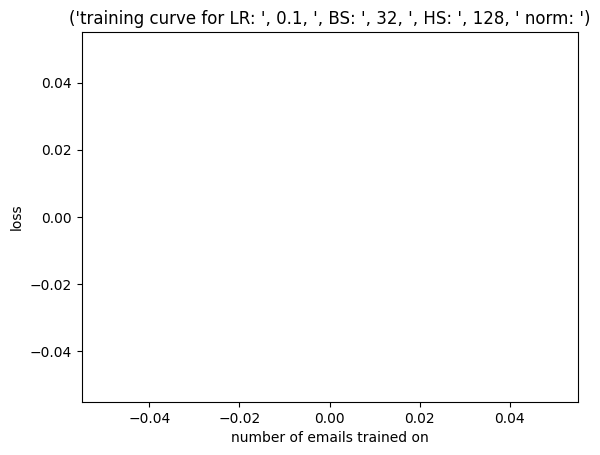

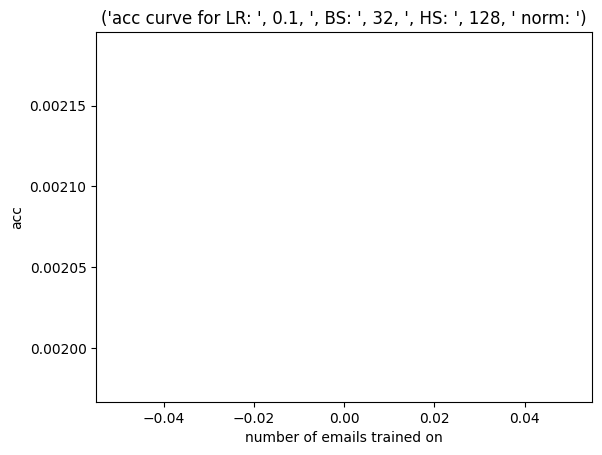

  2%|▏         | 7/375 [00:36<24:33,  4.00s/it]  

In [277]:
#initial overflow
#adam??
#its weird that the jumps get larger in the way that they do. seems to imply something is being carried over but im not sure
cell = train(dataset,input_size, 128, 32, 0.1, sequence_len,1)

In [174]:
from numpy import int64, int8


def get_output(cell, seed, length, input_size, batch_size, seq_len):

    text_out = seed
    

    seed = sp.encode_as_ids(seed)
    hot = np.array(one_hot(input_size,seed))
    print(hot.shape)

    prevA = np.zeros((1,hidden_size))
    prevC = np.zeros((1,hidden_size))

    # for i in range(len(hot)):
    #     print(np.atleashot[i].shape)

    # print(seed)

    dist = np.arange(0, input_size)
    # print(dist)

    for i in range(1, seq_len-1):

        inp = np.atleast_2d(hot[i])

        forward = forward_pass(cell, prevA, prevC, inp)

        prevA = forward["A_t"]
        prevC = forward["C_t"]
    
    inp = np.atleast_2d(hot[seq_len-1:seq_len])

    
    out = []
    for i in range(0, length):
        
        
        forward = forward_pass(cell, prevA, prevC, inp)

        inter_out = np.array(np.random.choice(dist, p=forward["Yhat"]))

        
        out.append(int(inter_out))

        inp = np.zeros(input_size)
        inp[out] = 1
        inp = np.atleast_2d(inp)

        prevA = forward["A_t"]
        prevC = forward["C_t"]

    

    text_out += sp.decode(out)

    return text_out


In [176]:
print(get_output(cell, "Hello, my name is Joseph K ", 50, 2500, 1, 15))

(15, 5000)
Hello, my name is Joseph K  ⁇  net ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  read copie ⁇  passengers death after ⁇ 155 ⁇  ⁇  ⁇  ⁇  the ⁇  ⁇  a ⁇  incurred is ing ⁇  ⁇  a consultancy ⁇  ⁇  ⁇  ⁇  ⁇ e my companiesor kin transfer ⁇  ⁇ ic ⁇ 
